In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import spatial
import time 
from tqdm.notebook import tqdm

## 1. Simulating the Lorenz Attractor

The equations that govern the Lorenz attractor are:

$$\frac{dx}{dt} = \sigma(y - x)$$

$$\frac{dy}{dt} = x(\rho - z) - y$$

$$\frac{dz}{dt} = xy - \beta z$$

where we set $\beta = \frac{8}{3}$ and $\sigma = 10$ based on https://itp.uni-frankfurt.de/~gros/Vorlesungen/SO/simulation_example/.

In [5]:
# dt, T are in milliseconds
def simulate_lorenz(rho, beta=8/3, sigma=10, dt=0.0001, T = 2, initial_condition=None):
    if initial_condition is None:
        initial_condition = np.random.normal(size=(3,))
    
    time_vals = np.arange(0, T + dt, dt)
    pts = np.zeros((len(time_vals), 3))
    pts[0] = initial_condition
    
    for t in range(1, len(time_vals)):
        x, y, z = pts[t - 1]
        dx = sigma*(y - x)
        dy = x*(rho - z) - y
        dz = x*y - beta*z
        
        x += dx*dt
        y += dy*dt
        z += dz*dt
        
        pts[t] = [x, y, z]
    
    return pts, time_vals

In [106]:
dt = 0.01
T = 40
lorenz_pts, time_vals = simulate_lorenz(28, dt=dt, T=T)

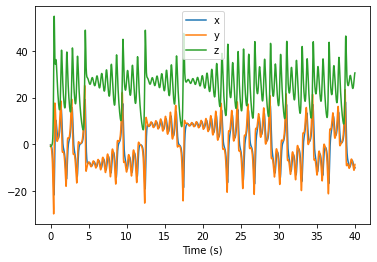

In [107]:
plt.plot(time_vals, lorenz_pts[:, 0], label='x')
plt.plot(time_vals, lorenz_pts[:, 1], label='y')
plt.plot(time_vals, lorenz_pts[:, 2], label='z')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

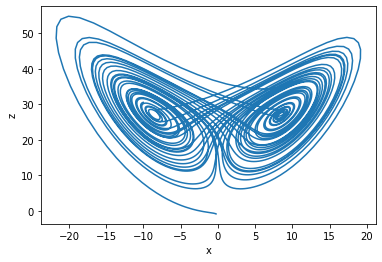

In [108]:
plt.plot(lorenz_pts[:, 0], lorenz_pts[:, 2])
plt.xlabel('x')
plt.ylabel('z')
plt.show()

## 2. Picking a Time Lag $\tau$

In [109]:
def autocorr(x, max_lag=None, progress_bar=False):
    n = len(x)
    if max_lag is None:
        max_lag = n - 1
    
    cov = np.zeros(max_lag + 1)
    sample_mean = np.mean(x)
    if progress_bar:
        iterator = tqdm(total = max_lag + 1)
    for lag in range(max_lag+1):
        cov[lag] = np.mean((x[lag:] - sample_mean)*(x[:n - lag] - sample_mean))
        if progress_bar:
            iterator.update()
    if progress_bar:
        iterator.close()
    
    corr = np.zeros(max_lag + 1)
    for lag in range(max_lag + 1):
        corr[lag] = cov[lag]/cov[0]
    
    return corr

In [110]:
signal = lorenz_pts[:, 1]

In [114]:
acorr = autocorr(signal, max_lag=None, progress_bar=True)

In [115]:
tau = np.argmax(acorr < 0)
print(f"The chosen time lag tau = {tau} ({tau*dt:.2f} seconds)")

The chosen time lag tau = 210 (2.10 seconds)


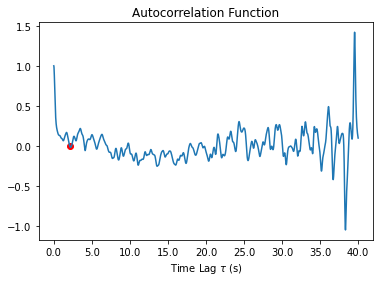

In [116]:
plt.plot(acorr)
plt.title('Autocorrelation Function')
plt.xlabel(r'Time Lag $\tau$ (s)')
xticks = plt.xticks()[0][1:-1]
plt.xticks(xticks, xticks*dt)
plt.scatter(tau, 0, c='red')
plt.show()

## 3. Pick an Embedding Dimension

To implement false nearest neighbours:

$$X_{\text{fnn}}(r) = \frac{\sum_{n=1}^{N - m-1} \Theta \left(\frac{\vert x^{(m+1)}_n - x^{(m+1)}_{k(n)} \vert}{\vert x^{(m)}_n - x^{(m)}_{k(n)} \vert} - r\right)\Theta\left(\frac{\sigma}{r} - \vert x^{(m)}_n - x^{(m)}_{k(n)} \vert\right)}{\sum_{n=1}^{N - m-1}\Theta\left(\frac{\sigma}{r} - \vert x^{(m)}_n - x^{(m)}_{k(n)} \vert\right)}$$

where $r$ is a threshold, $m$ is the embedding demension, $k(n)$ is the nearest neighbour to point $n$, and $\Theta$ is a step function.

Or, alternatively, compute

$$R_i = \frac{\vert x^{(m)}_n - x^{(m)}_{k(n) + 1} \vert}{\vert x^{(m)}_n - x^{(m)}_{k(n)} \vert}$$

and declare a false nearest neighbor if $R_i$ is greater than some threshold $r$.

In [166]:
m = 3
p = 2
r = 1

In [167]:
def embed_signal(x, m, tau):
    embedding = np.zeros((len(x) - m*tau, m))
    for n in range(len(x) - m*tau):
        for mult in range(m):
#             print(f"item [{n}, {mult}] = x[{n + mult*tau}]")
            embedding[n, mult] = x[n + mult*tau]
    
    return embedding

In [168]:
embedding = embed_signal(signal, m, tau=tau)

In [169]:
# # brute force
# start = time.process_time()
# # euclidean is L2, cityblock is L1, chebyshev, is Linfinity
# pdist = spatial.distance.cdist(embedding, embedding, metric='chebyshev')

# # remove the diagonal
# pdist = pdist[~np.eye(pdist.shape[0],dtype=bool)].reshape(pdist.shape[0],-1)
# nn_indices_brute = np.zeros(pdist.shape[0], dtype=np.int)
# min_dist_brute = np.zeros(pdist.shape[0])
# for i in range(pdist.shape[0]):
#     min_ind = pdist[i, :].argmin()
#     min_dist_brute[i] = pdist[i, min_ind]
#     nn_indices_brute[i] = min_ind + 1 if min_ind >= i else min_ind

# end = time.process_time()
# print(f"pdist took {end - start:.3f} s")

# start = time.process_time()
# kdTree = spatial.cKDTree(embedding, leafsize=100)
# nn = kdTree.query(embedding, k=2, p=p)
# nn_indices = nn[1][:, 1]
# min_dist = nn[0][:, 1]
# end = time.process_time()
# print(f"pdist took {end - start:.3f} s")

# np.array_equal(nn_indices, nn_indices_brute)

# for i, (n1, n2) in enumerate(zip(nn_indices, nn_indices_brute)):
#     if n1 != n2:
#         print(f"n1 = {n1} with dist {min_dist[i]:.8f} n2 = {n2} with dist {min_dist_brute[i]:.8f} at {i}")

In [170]:
def get_nn_indices(pts, p=2):
    kdTree = spatial.cKDTree(pts, leafsize=100)
    nn = kdTree.query(embedding, k=2, p=p)
    nn_indices = nn[1][:, 1]
    min_dist = nn[0][:, 1]
    
    return nn_indices, min_dist

def get_metric(p):
    if p == 1:
        return spatial.distance.cityblock
    elif p == 2:
        return spatial.distance.euclidean
    elif p == np.Inf:
        return spatial.distance.chebyshev
    else:
        return lambda u, v: scipt.distance.minkowski(u, v, p=p)

def calculate_fnn_stat(pts, nn_indices, r, p=2):
    metric = get_metric(p)
    
    N = pts.shape[0]
    nn_distances = []
    nn_next_step_distances = []
    
    for i in range(N-1):
        if nn_indices[i] + 1 < N:
            nn_distances.append(metric(pts[i], pts[nn_indices[i]]))
            nn_next_step_distances.append(metric(pts[i+1], pts[nn_indices[i]+1]))
    
    nn_distances, nn_next_step_distances = np.array(nn_distances), np.array(nn_next_step_distances)
    ratios = nn_next_step_distances/nn_distances
    fraction_greater = np.sum(ratios > r)/len(ratios)
    return fraction_greater, ratios

In [171]:
nn_indices, _ = get_nn_indices(embedding, p=p)
fraction_greater, ratios = calculate_fnn_stat(embedding, nn_indices, r, p=p)

for m = 3, 72.226% of transitions are greater than r = 1 under 2-norm


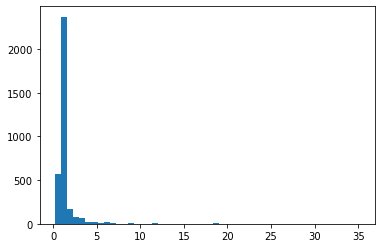

In [173]:
print(f"for m = {m}, {fraction_greater*100:.3f}% of transitions are greater than r = {r} under {p}-norm")
plt.hist(ratios, bins=50)
plt.show()

In [182]:
p = 1
r = 10

M_vals = np.arange(1, 5)
fraction_fnn = np.zeros(M_vals.shape)

for i, m in enumerate(M_vals):
    embedding = embed_signal(signal, m, tau=tau)
    nn_indices, _ = get_nn_indices(embedding, p=p)
    fraction_greater, ratios = calculate_fnn_stat(embedding, nn_indices, r, p=p)
    fraction_fnn[i] = fraction_greater

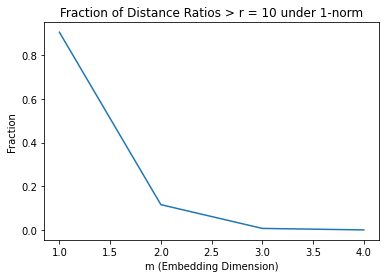

In [183]:
plt.plot(M_vals, fraction_fnn)
plt.xlabel('m (Embedding Dimension)')
plt.title(f'Fraction of Distance Ratios > r = {r} under {p}-norm')
plt.ylabel('Fraction')
plt.show()